# Chapter 4: Building Good Training Data Sets - Data Preprocessing

# 4-1: Dealing with Missing Data

Most computational models cannot handle missing values in a data set, and would produce unpredicatable results if not addressed.

In [4]:
import pandas as pd
from io import StringIO
csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''
csv_data=unicode(csv_data)
df=pd.read_csv(StringIO(csv_data))
print df

df.isnull().sum()

      A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN


A    0
B    0
C    1
D    1
dtype: int64

### Eliminating samples or features with missing values

In [5]:
# drop observations with Null values
null_obs=df.dropna()

# drop columns with any null values
null_col=df.dropna(axis=1)

# only drop rows were all columns are NaN
null_col_all=df.dropna(how='all')

# drop rows that do not have at least 4 non-NaN values
at_least = df.dropna(thresh=4)

# only drop rows where NaN appears in specific columns (here: 'C')
drop_specific = df.dropna(subset=['C'])

### Imputing missing values

When dropping NaNs is not feasible, youc an use different interpolation techniques to estimate the missing values from the other training samples in your dataset.

In [9]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy = 'mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

### Understanding scikit-learn *transformer* classes

The two essential methods of estimators in this class are:

**(1) fit**: Used to learn the parametrs from the training data

**(2) transform**: Uses those parameters to transform the data

*Note: the classifiers from Chapter 3 belong to the **estimator** class within scikit-learn, and have a **predict** method*

# 4-2: Handling categorical data

First, understand **nominal** vs. **ordinal** features. Ordinal features can be sorted (i.e. t-shirt sizes), while nominal features do not imply an order (i.e. t-shirt colors).

We'll create a new df to illustrate:

In [33]:
import pandas as pd
df = pd.DataFrame([
    ['green','M',10.1,'class1'],
    ['red','L',13.5,'class2'],
    ['blue','XL',15.3,'class1']])
df.columns = ['color','size','price','classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### Mapping ordinal features

Mapping an oridinal feature to an integer is a manual process, and we must scale the difference in values accordingly

In [34]:
size_mapping = {
    'XL':3,
    'L':2,
    'M':1}
df['size'] = df['size'].map(size_mapping)
print df

# You can always define and inverse mapping to revert to original labels

inv_size_mapping = {v: k for k, v in size_mapping.items()}

   color  size  price classlabel
0  green     1   10.1     class1
1    red     2   13.5     class2
2   blue     3   15.3     class1


### Encoding Class Labels

While class labels are *not* ordinal, many algorithms still require these labels are passed as integers. You can begin coding at 0, though this will be suboptimal with greater than 2 features

In [28]:
import numpy as np
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
print class_mapping

df['classlabel'] = df['classlabel'].map(class_mapping)

df

{'class2': 1, 'class1': 0}


,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


#### Inverse Mapping

In [8]:
#inv_class_mapping = {v: k for k,v in class_mapping.items()}
#df['classlabel'] = df['classlabel'].map(inv_class_mapping)
#df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


#### Or, use the LabelEncoder

In [29]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
#fit_transform is a shorcut for calling fit and transform separately

y

array([0, 1, 0])

#### And inverse...

In [11]:
# class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### Performing one-hot encoding on nominal features

In the case where you have multiple classifiers, you'll want to create a new **dummy feature** for reach unique value rather than convert to sequential integers as before. This is called **one-hot** encoding.

The old way:

In [35]:
X = df[['color','size','price']].values
color_le = LabelEncoder()
X[:,0] = color_le.fit_transform(X[:,0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

The new way:

In [36]:

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

When initializing the `OneHotEncoder`, we define the column position of the variable that we want to transform via `categorical_features`. By default, the resulting sparse matrix must be converted to a *dense* **NumpyArray** via `toarray()`. To skip the `toarray()`, you could initialize the encoder as `OneHotEncoder(...,sparse=False)` instead.

### Or even better... just use `GetDummies`!

In [38]:
pd.get_dummies(df[['price','color','size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


# 4-3: Partitioning a dataset in training and test sets

The **test set** is the *ultimate test* of your model before letting it loose on the real world.

### The Wine Dataset

In [40]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label',
                  'Alcohol',
                  'Malic acid',
                  'Ash',
                  'Alcalinity of ash',
                  'Magnesium',
                  'Total phenols',
                  'Flavanoids',
                  'Nonflavanoid phenols',
                  'Proanthocyanins',
                  'Color intensity',
                  'Hue',
                  'OD280/OD315 of diluted wines',
                  'Proline']

print('Class labels', np.unique(df_wine['Class label']))

df_wine.head()

('Class labels', array([1, 2, 3]))


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### Partition dataset into train & test

In [44]:
from sklearn.cross_validation import train_test_split
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 70/30 train/test split

# 4-4: Bringing features onto the same scale

**Feature scaling** is a crucial step in **preprocessing** required by the majority of machine learning algorithms (with decision trees/random forests the exception). Without scaling, algorithms will assign greater weighting to variables with larger standard errors. *E.G. Euclidean distance between samples much greater for a high scale variable than low scale.*

Two common approaches to scaling: 

(1) **Normalization**: Typically, scaling features to a range of [0,1]

(2) **standardization**: Scales to a mean of 0 with a standard deviation of 1 so that the feature columns take the form of a normal distribution, aking it easier to learn the weights. Useful for logistic regressions and SVM.

In [46]:
# Normalization

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [47]:
# Standardization

from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# 4-5: Selecting meaningful features

If a model performs much better on a training dataset than on the test dataset, it is likely we are experiencing **overfitting**, meaning that the model fits the parameters *too closely* to the particular observations in the training dataset, but does not generalize well to real data. i.e. the model is too complex and has a *high variance*.

To reduce overfitting:
* Collect more training data
* Introduce a penalty for complexity via **regularization**
* Choose a simpler model with fewer parameters
* **Reduce the dimensionality** of the data

## Sparse solutions with L1 regularization

Recall, **L2 regularization** is one approach to reduce the complexity of a model by penalizing large individual weights. **L1 Regularization** is similar, except that we replace the square of the weights in the error function with the absolute values of the weights. As a result, L1 will yield a sparse feature vector (i.e. many features will be weighted at 0, thus removing them from the model).

More on differences between L1 & L2 here: http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/

Recall the **cost function** is the error minimization problem we are trying to solve.

In [53]:
from sklearn.linear_model import LogisticRegression
#use L1 penalty in cost function

lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std,y_test))

('Training accuracy:', 0.9838709677419355)
('Test accuracy:', 0.98148148148148151)


*The above results do not indicate any overfitting*

In [55]:
lr.intercept_

array([-0.3838111 , -0.1580829 , -0.70043477])

The **OvR (One-vs-Rest)** approach is used above by default, meaning the first intercept is class 1 vs 2 & 3, the second intercept is class 2 vs 1 & 3, and the third is class 3 vs 1 & 2.

Now, show the weight vector for each class (3 in total, each consisting of 13 coefficients correspond with the 13-dimensional dataset)

In [58]:
lr.coef_

array([[ 0.27997903,  0.        ,  0.        , -0.02796621,  0.        ,
         0.        ,  0.70996267,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23678374],
       [-0.64398006, -0.06883369, -0.05719931,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92675874,
         0.06014968,  0.        , -0.37109031],
       [ 0.        ,  0.06154486,  0.        ,  0.        ,  0.        ,
         0.        , -0.63559017,  0.        ,  0.        ,  0.49786905,
        -0.35840308, -0.57152552,  0.        ]])

*Note: the weight vectors above are very sparse (many 0s)*

### Plotting the regularization path

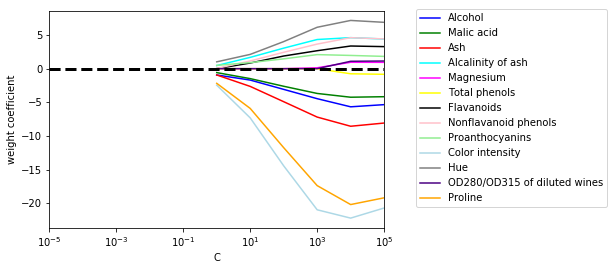

In [65]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue','green','red','cyan','magenta','yellow','black','pink','lightgreen','lightblue','gray','indigo','orange']
weights, params = [], []
for c in np.arange(0,6):
    lr = LogisticRegression(penalty='l1',
                           C=10**c,
                           random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, 
             weights[:, column],
             label=df_wine.columns[column+1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5),10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
         bbox_to_anchor=(1.38, 1.03),
         ncol=1,
         fancybox=True)
plt.show()

#supposed to cover -4 to 6, but still getting that negative exponent error!

The stronger the regularizaiton (closer to the origin on the x-axis, the more the weights converge to 0)

## Sequential feature selection algorithms

**Dimensionality reduction** can take two forms:

(1) **Feature selection**: Choosing an optimal subset of features from the feature space 
(2) **Feature extraction**: Deriving information form the feature set to construct a new feature subspace

Benefits of feature selection:
* improve computational efficiency
* reduce the generalization error of the model (i.e. reduce overfitting to training set)


### **Sequential Backward Selection (SBS)**

A "greedy algorithm" aiming to reduce the dimensionality of your model with minimum decay in performance. In some cases, SBS can improve the predictive power of the model if the model suffers from overfitting. SBS removes features from the full feature subset until the new feature subspace contains the optimal number of features.

In [81]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

Above, the `k_features` parameter is used to specify the desired number of features we want to return. We utilize the `accuracy_score` to calculate the preceding impact of removing a featre from the feature set. `self` stores the best overall subset of features that these iterations produce. `self.indices_` stores column indices for the final feature subset, which we can use to create a new data array with the selected features via the `transform` method.

### SBS in action

In [82]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

<__main__.SBS instance at 0x1134f4170>

Explain above

### Now plot the classification accuracy of the KNN classifier above

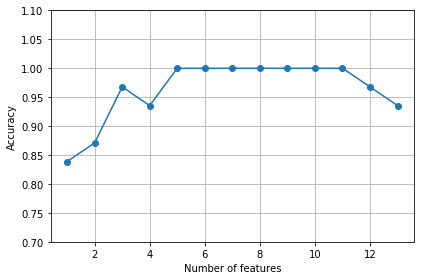

In [85]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

Above, accuracy peaks for k between 5 and 11 and is lower for k = 12,13

In [86]:
 k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index([u'Alcohol', u'Malic acid', u'Alcalinity of ash', u'Hue', u'Proline'], dtype='object')


In [87]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

('Training accuracy:', 0.9838709677419355)
('Test accuracy:', 0.94444444444444442)


In [88]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

('Training accuracy:', 0.95967741935483875)
('Test accuracy:', 0.96296296296296291)


Above, implementing our improved feature set improves our test accuracy

*Note: other feature selection algorithms exist in scikit-learn, detailed here: *

http://scikit-learn.org/stable/modules/feature_selection.html

# 4-5: Assessing feature importance with Random Forests

Using RFs, we can measure feature importance as the averaged **impurity decrease** computed from all decision trees in the forest. In a RF, the measure based on which the optimal condition is chosen for a particular node is called impurity. Therefore, impurity decrease refers to the decrease is differentiation resulting from the removal of a particular feature.

Scikit-learn has built-in feature importance functionality for RFs: `feature_importances_`

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


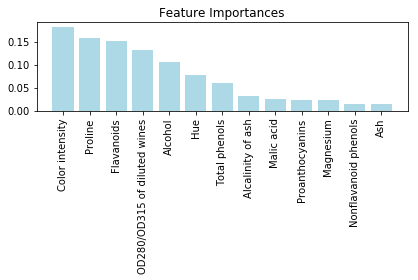

In [90]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

The above results are normalized so the sum of feature importance = 1.

**Multicolinearity warning**: If two or more features are highly correlated in a RF, one feature may be ranked very highly while the information of the other feature(s) may not be fully captured.

Below, we can establish a threshold for feature importance in our model.

In [92]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.15, prefit=True)
X_selected = sfm.transform(X_train)

X_selected.shape

(124, 3)